In [3]:
# %load_ext cudf.pandas
# %pip install pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 MB 19.2 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import pandas as pd
import numpy as np
import glob
import datetime
from datetime import datetime
import bz2
import re
import glob
from tqdm import tqdm
import random
from datetime import timedelta

# This mutes useless warnings:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [4]:
#first preprocess the data with:
# This will take a VERY long time, I recommend running in the terminal
# !python dataloader.py
# %pip install metar-taf-parser-mivek

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.1/107.1 kB 730.9 kB/s eta 0:00:00 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
from data_loader import NASAAirportDataset

# this will take a while
# train_ds = NASAAirportDataset('KCLT', 'data/preprocess/train', n_presamples=10_000, scale_min=0, scale_max=1)
train_ds = NASAAirportDataset('KCLT', 'data/preprocess/train', n_presamples=10, scale_min=0, scale_max=1)



loading first position
loading lamp
loading runways
loading mfs
loading tbfm
load tfm
normalizing numeric and categorical data
aircraft_engine_class_JET
aircraft_engine_class_PISTON
aircraft_engine_class_TURBO
aircraft_engine_class_nan
aircraft_type_A124
aircraft_type_A139
aircraft_type_A20N
aircraft_type_A21N
aircraft_type_A306
aircraft_type_A319
aircraft_type_A320
aircraft_type_A321
aircraft_type_A332
aircraft_type_A333
aircraft_type_A339
aircraft_type_A345
aircraft_type_A346
aircraft_type_A359
aircraft_type_A35K
aircraft_type_AA5
aircraft_type_AC11
aircraft_type_AC50
aircraft_type_AC90
aircraft_type_AC95
aircraft_type_AEST
aircraft_type_AS50
aircraft_type_ASTR
aircraft_type_B190
aircraft_type_B350
aircraft_type_B38M
aircraft_type_B39M
aircraft_type_B412
aircraft_type_B429
aircraft_type_B58T
aircraft_type_B712
aircraft_type_B722
aircraft_type_B734
aircraft_type_B735
aircraft_type_B737
aircraft_type_B738
aircraft_type_B739
aircraft_type_B744
aircraft_type_B752
aircraft_type_B753
aircr

100%|██████████| 10/10 [00:33<00:00,  3.37s/it]


In [ ]:

import pickle
# pickle.dump(train_ds, open('train_ds.pkl', 'wb'))
test_ds = NASAAirportDataset('KCLT', 'data/preprocess/train', n_presamples=100, scale_min=0, scale_max=1)
# pickle.dump(test_ds, open('test_ds.pkl', 'wb'))
#


loading first position
loading lamp
loading runways
loading mfs
loading tbfm
load tfm
normalizing numeric and categorical data
gathering presamples ...


 19%|█▉        | 19/100 [00:53<03:29,  2.58s/it]

In [6]:

pickle.dump(train_ds, open('train_ds.pkl', 'wb'))
# pickle.dump(test_ds, open('test_ds.pkl', 'wb'))

In [33]:
import pickle

train_ds = pickle.load(open('train_ds.pkl', 'rb'))
train_ds = pickle.load(open('train_ds.pkl', 'rb'))



In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AirportThroughputModel(nn.Module):
    def __init__(self, input_dim: int, hidden_dims=[256, 128, 64], output_dim=12, dropout=0.3):
        super(AirportThroughputModel, self).__init__()

        # Define a simple feed-forward network with batch norm and dropout
        layers = []
        prev_dim = input_dim
        for hdim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hdim))
            layers.append(nn.BatchNorm1d(hdim))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(dropout))
            prev_dim = hdim
        # Final output layer
        layers.append(nn.Linear(prev_dim, output_dim))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        logits = self.network(x)
        return logits


# Example usage:
# Suppose you have a single batch from the dataset:
# x, y = next(iter(data_loader))
# input_dim = x.shape[1]  # number of features
# model = AirportThroughputModel(input_dim=input_dim)
# model = model.to('cuda')  # or 'cpu', depending on your setup
# output = model(x)
# loss = criterion(output, y.argmax(dim=1))  # if y is one-hot encoded


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from data_loader import NASAAirportDataset

# Assuming you have created these datasets already
# train_dataset = NASAAirportDataset(...)
# val_dataset = NASAAirportDataset(...)

# Example DataLoaders
print(len(train_ds))

# Example model instantiation
# First, let's fetch a single batch to determine input_dim (if not known ahead of time)
# x_sample, y_sample = next(iter(train_loader))
input_dim = 1326 #  x_sample.shape[1]
model = AirportThroughputModel(input_dim=input_dim, hidden_dims=[256, 128, 64], output_dim=13, dropout=0.3)

# Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        # Convert one-hot target to class indices
        y_indices = y.argmax(dim=1)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y_indices)
        if loss.isnan():
            # print('NaN in loss')
            continue
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        # Compute accuracy
        _, preds = torch.max(logits, 1)
        correct += (preds == y_indices).sum().item()
        total += x.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            y_indices = y.argmax(dim=1)

            logits = model(x)
            loss = criterion(logits, y_indices)
            if loss.isnan():
                # print('NaN in loss')
                continue
            running_loss += loss.item() * x.size(0)
            _, preds = torch.max(logits, 1)
            correct += (preds == y_indices).sum().item()
            total += x.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

losses = []
# Training loop
num_epochs = 10_000

airports = set([os.path.basename(file) for file in glob.glob("data/FUSER_test/*")])
for terminal in airports:
    print(terminal)
    for meta_epoc in range(100):
        print('fold:', meta_epoc)
        train_ds = NASAAirportDataset(terminal, 'data/preprocess/train', n_presamples=10, scale_min=0, scale_max=1)
        test_ds = NASAAirportDataset(terminal, 'data/preprocess/train', n_presamples=10, scale_min=0, scale_max=1)
        train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, drop_last=False, num_workers=4)
        val_loader = DataLoader(test_ds, batch_size=64, shuffle=False, drop_last=False, num_workers=4)

        for epoch in (pbar := tqdm(range(num_epochs))):
            train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
            val_loss, val_acc = validate(model, val_loader, criterion, device)
            losses.append(train_loss)
            # print(f"Epoch {epoch+1}/{num_epochs}")
            # print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
            pbar.set_description(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
            # print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

        # After training, you can save the model:
        torch.save(model.state_dict(), f"{terminal}_airport_throughput_model.pth")



In [7]:
import torch

print(train_ds[0][0].shape)

x_sample, y_sample = train_ds[0]
input_dim = x_sample.shape
input_dim
y_sample.shape




torch.Size([1326])


torch.Size([13])

In [34]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# dataset = NASAAirportDataset(airport_code='KJFK', data_dir='/path/to/data', lamp_df=lamp_df, to_tensor=True)


input_dim = 1326
output_dim = 4 * 3 + 1  # 15 min intervals across 3 hours
hidden_dim = 64

class SimpleFeedForward(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleFeedForward, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        return self.layers(x)

model = SimpleFeedForward(input_dim, hidden_dim, output_dim)
model.to('cuda')

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 1000
model.train()
losses = []
# for epoch, time in (pbar := tqdm(enumerate(time_sampler(num_epochs)))):
for epoch in range(num_epochs):
    running_loss = 0.0
    epoch_len = 0
    n_steps = len(train_ds)

    for x_batch, y_batch in (pbar := tqdm(data_itr(n_steps), total=n_steps)):
        if(len(x_batch) == 0):
            pbar.set_description(f"Epoch [{epoch+1}/{num_epochs}], running_loss: {running_loss :.4f}, Loss: (no flights at timestep)")
            continue
        epoch_len = len(x_batch)
        optimizer.zero_grad()
        outputs = model(x_batch)  # forward pass
        loss = criterion(outputs, y_batch)
        if loss.isnan():
            print("Error: nan loss.... WHY?!?!?!?")
            continue
        loss.backward()  # backpropagate
        optimizer.step()  # update weights

        running_loss += loss.item() * x_batch.size(0)
        losses.append(loss)
        pbar.set_description(f"Epoch [{epoch+1}/{num_epochs}], running_loss: {running_loss :.4f}, Loss: {loss :.4f}")

    epoch_loss = running_loss / epoch_len
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss :.4f}")

print("Training completed.")




NameError: name 'data_itr' is not defined

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 33.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 856.9 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 GB 690.6 kB/s eta 0:00:000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 GB 515.8 kB/s eta 0:00:000:01m00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 3.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 32.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 919.9/919.9 kB 11.7 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 1.7 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 19.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 839.3/839.3 MB 1.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

6406


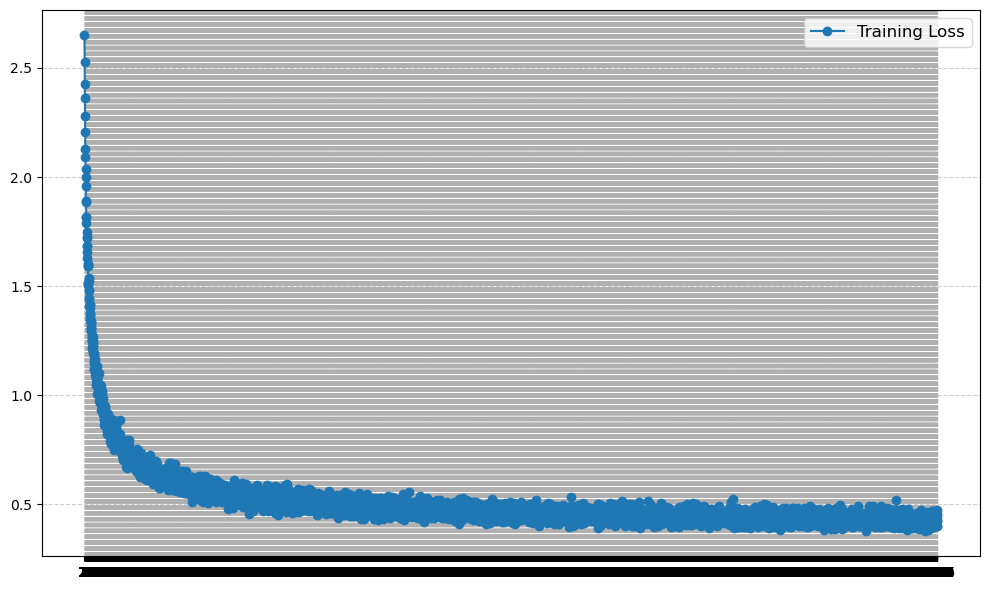

In [17]:

import matplotlib.pyplot as plt
# losses = [x.item() for x in losses]
print(len(losses))
plt.figure(figsize=(10, 6))
plt.plot(losses, marker='o', linestyle='-', label="Training Loss")
# plt.title(title, fontsize=16)
# plt.xlabel(xlabel, fontsize=12)
# plt.ylabel(ylabel, fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(range(len(losses)))  # Show ticks for each epoch
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()